In [9]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from os.path import expanduser
from lib.definitions.classdefinitions import *
import lib.plot as plot
import lib.filter as filter
import lib.compare as scmp
import lib.sqlite_load as sq
import lib.util as util
import prettyprinter as pp
import pandas as pd
import logging
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

logging.basicConfig(level=logging.CRITICAL)
vp = VantagePoint()
#source_flow_labels = [0, 255, 65280, 983040, 1048575]
home = expanduser("~")
# Large data:
#db_dir = home + "/db-storage/large-data/*.db"
#db_path = home + "/db-storage/large-data/db-ubuntu-ams3-0-2023-01-19T23_00_25Z.db"
# Test/small data:
db_dir = home + "/git/scripts/stats/sample-data/db/*.db"
db_path = home + "/git/scripts/stats/sample-data/db/db-ubuntu-fra1-0-2023-01-22T17_04_15Z.db"
df: pd.DataFrame = sq.load_single(db_path)
FL_IDX = 0
#for flow_label in source_flow_labels:
    #print(f"Distribution of equal paths with flow label {flow_label}:")
    #dist = util.get_distribution_of_equal_paths_to_destination(
        #df, flowlabel=flow_label)
    #fig, ax = plt.subplots()
    #bars = ax.bar([str(i) for i in dist.index], dist)
    #ax.bar_label(bars)
    #plt.title(f"Flow label: {flow_label}")

def create_flow_label_distribution(flow_label, vantage_point):
    print(f"Distribution of equal paths with flow label {flow_label}:")
    dist = util.get_distribution_of_equal_paths_to_destination(
        df, flowlabel=flow_label)
    fig, ax = plt.subplots()
    bars = ax.bar([str(i) for i in dist.index], dist)
    ax.bar_label(bars)
    plt.title(f"Vantage point: {vantage_point} \nFlow label: {flow_label}")


## Flow label distributions
## VP: ams

Distribution of equal paths with flow label 0:


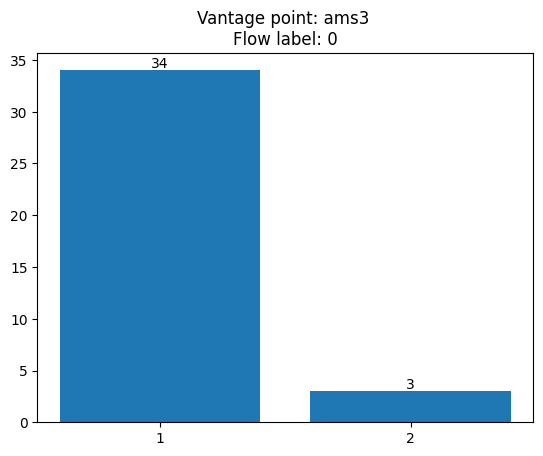

In [10]:
create_flow_label_distribution(FlowLabels.FL_0, vp.ams)

Distribution of equal paths with flow label 255:


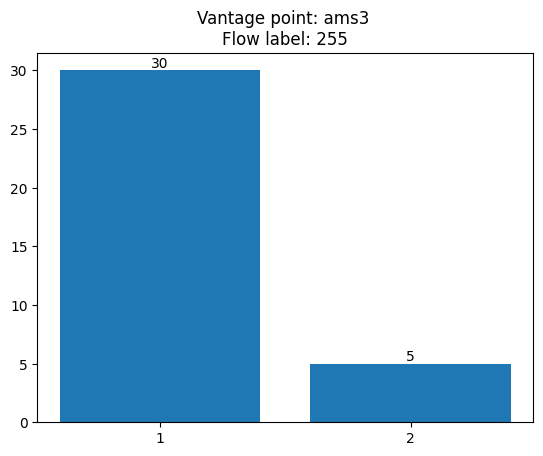

In [11]:
create_flow_label_distribution(FlowLabels.FL_255, vp.ams)

Distribution of equal paths with flow label 65280:


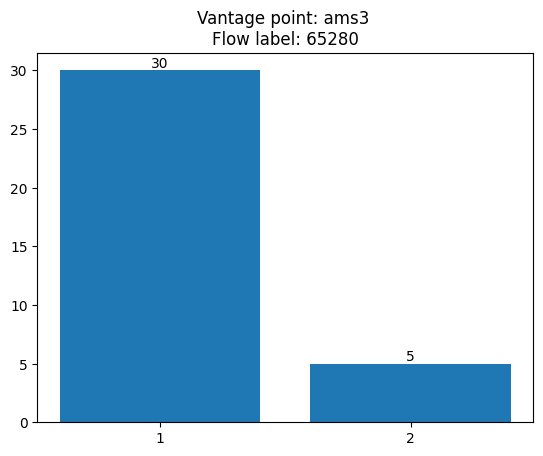

In [12]:
create_flow_label_distribution(FlowLabels.FL_65280, vp.ams)

Distribution of equal paths with flow label 983040:


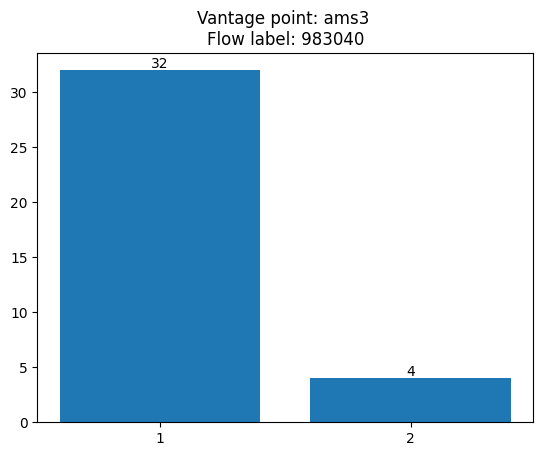

In [13]:
create_flow_label_distribution(FlowLabels.FL_983040, vp.ams)

Distribution of equal paths with flow label 1048575:


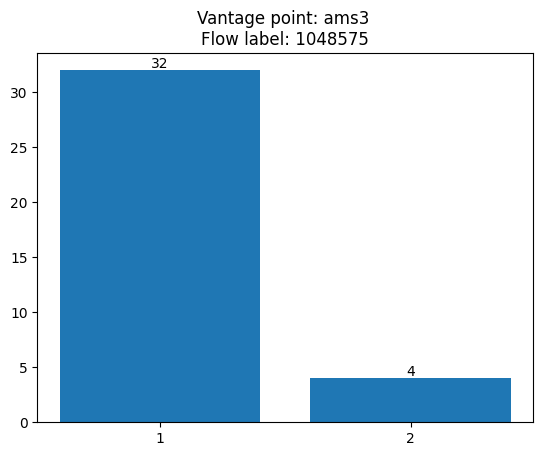

In [14]:
create_flow_label_distribution(FlowLabels.FL_1048575, vp.ams)

## Flow label distributions
## VP: blr

Distribution of equal paths with flow label 0:


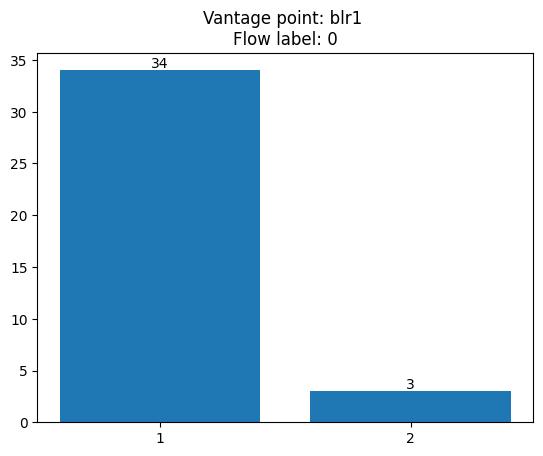

In [15]:
create_flow_label_distribution(FlowLabels.FL_0, vp.blr)